In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from eumap.misc import find_files, ttprint, nan_percentile, GoogleSheet
from eumap.raster import read_rasters, save_rasters
import warnings
import multiprocess as mp
import time
from scipy.special import expit, logit
import warnings
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
import joblib
import pickle
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from cubist import Cubist
from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
import os
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import cross_val_predict
import math

df = pd.read_csv(f'/mnt/primus/xuemeng_tmp_harbour/soc/data/002_data_whole.csv',low_memory=False)

<Axes: >

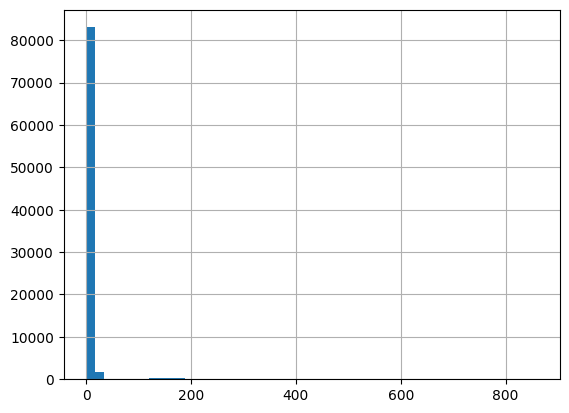

In [19]:
prop = 'N'
df.loc[df[f'{prop}_qa']>5,prop].hist(bins=50)

In [23]:

prop_list = ['ph_h2o','ph_cacl2','bulk_density','oc'] #'bulk_density','oc','caco3',
path_list = ['/mnt/primus/xuemeng_tmp_harbour/soc/results/ph_h2o/model_rf.ph_h2o_normal.ccc.joblib',
             '/mnt/primus/xuemeng_tmp_harbour/soc/results/ph_cacl2/model_rf.ph_cacl2_normal.ccc.joblib',
             '/mnt/primus/xuemeng_tmp_harbour/soc/results/bulk_density/model_lgb.bulk_density_normal.ccc.joblib',
             '/mnt/primus/xuemeng_tmp_harbour/soc/results/oc/model_rf.oc_log1p.ccc.joblib']

covs_list = ['/mnt/primus/xuemeng_tmp_harbour/soc/results/ph_h2o/benchmark_selected.covs_ph_h2o.txt',
             '/mnt/primus/xuemeng_tmp_harbour/soc/results/ph_cacl2/benchmark_selected.covs_ph_cacl2.txt',
             '/mnt/primus/xuemeng_tmp_harbour/soc/results/bulk_density/benchmark_selected.covs_bulk_density.txt',
             '/mnt/primus/xuemeng_tmp_harbour/soc/results/oc/benchmark_selected.covs_oc.txt']

In [24]:
import shutil
n_jobs=90
for ii in [3]:#range(len(covs_list)):
    # target property
    prop = prop_list[ii]
    print(f'process {prop}')
    # model
    model = joblib.load(path_list[ii])
    namef = 'propduction.' + path_list[ii].split('/')[-1]
    # update model's n_jobs
    if hasattr(model, 'steps'):  # Check if it's a Pipeline
        for name, estimator in model.steps:
            if hasattr(estimator, 'n_jobs'):
                estimator.n_jobs = n_jobs
                print(f"Updated n_jobs to {n_jobs} for '{name}' in the pipeline.")
    elif hasattr(model, 'n_jobs'):  # Check if it's a model with n_jobs
        model.n_jobs = n_jobs
        print(f"Updated n_jobs to {n_jobs} for model {namef}.")
    else:
        print("This object does not support the 'n_jobs' parameter.")
        
    # covariates
    covs_a = pd.read_csv(covs_list[ii]).values.tolist()
    covs = [item for sublist in covs_a for item in sublist]
    
    # all the data
    dff = df.dropna(subset=covs+[prop],how='any')
    
    # fit the model
    model.fit(dff[covs],dff[prop])
    joblib.dump(model,f'/mnt/primus/xuemeng_tmp_harbour/soc/results/production_model/{namef}')
    shutil.copy(covs_list[ii], covs_list[ii].replace(f'results/{prop}','results/production_model'))

process oc
Updated n_jobs to 90 for model propduction.model_rf.oc_log1p.ccc.joblib.
